In [ ]:
import torch

In [ ]:
import yaml
# Pulled from trunk on github (e67dc9f64dd787a9bc7294ee1141d3355fe2e831)
config_path = None # pass config path
cfg = yaml.safe_load(open(config_path))

In [ ]:
from etflow.utils import instantiate_model
ckpt_path = None # pass ckpt path
model = instantiate_model(cfg['model'], cfg['model_args'])
model.load_state_dict(torch.load(ckpt_path)['state_dict'])

2024-11-04 19:40:24.313 | INFO     | etflow.utils:instantiate_model:137 - Loading BaseFlow with args: {'network_type': 'TorchMDDynamics', 'hidden_channels': 160, 'num_layers': 20, 'num_rbf': 64, 'rbf_type': 'expnorm', 'trainable_rbf': True, 'activation': 'silu', 'neighbor_embedding': True, 'cutoff_lower': 0.0, 'cutoff_upper': 10.0, 'max_z': 100, 'node_attr_dim': 10, 'edge_attr_dim': 1, 'attn_activation': 'silu', 'num_heads': 8, 'distance_influence': 'both', 'reduce_op': 'sum', 'qk_norm': True, 'so3_equivariant': False, 'clip_during_norm': True, 'parity_switch': 'post_hoc', 'sigma': 0.1, 'prior_type': 'harmonic', 'interpolation_type': 'linear', 'optimizer_type': 'AdamW', 'lr': 0.0008, 'weight_decay': 1e-08, 'lr_scheduler_type': 'CosineAnnealingWarmupRestarts', 'first_cycle_steps': 375000, 'cycle_mult': 1.0, 'max_lr': 0.0005, 'min_lr': 1e-08, 'warmup_steps': 0, 'gamma': 0.05, 'last_epoch': -1, 'lr_scheduler_monitor': 'val/loss', 'lr_scheduler_interval': 'step', 'lr_scheduler_frequency': 

<All keys matched successfully>

In [6]:
model.to('cuda');

#### Generate Conformation

In [7]:
from etflow.commons.sample import batched_sampling
from etflow.commons.featurization import MoleculeFeaturizer

feat = MoleculeFeaturizer()
smiles = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
data = feat.get_data_from_smiles(smiles)
num_samples_to_generate = 8
gen_position = batched_sampling(model, data, max_batch_size=8, num_samples=num_samples_to_generate, seed=42, device='cuda')

[rank: 0] Seed set to 42
/mnt/ps/home/CORP/nikhil.shenoy/projects/ETFlow/etflow/commons/utils.py:177: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/torch/csrc/utils/tensor_new.cpp:618.)
  bgraph_adj = torch.sparse.LongTensor(edge_index, edge_type, torch.Size([N, N]))


#### Visualize Conformation

In [8]:
import py3Dmol # might have to pip install this for viz
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize = (600, 600)   # Change image size
IPythonConsole.ipython_useSVG = True  # Change output to SVG
IPythonConsole.ipython_3d = True

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

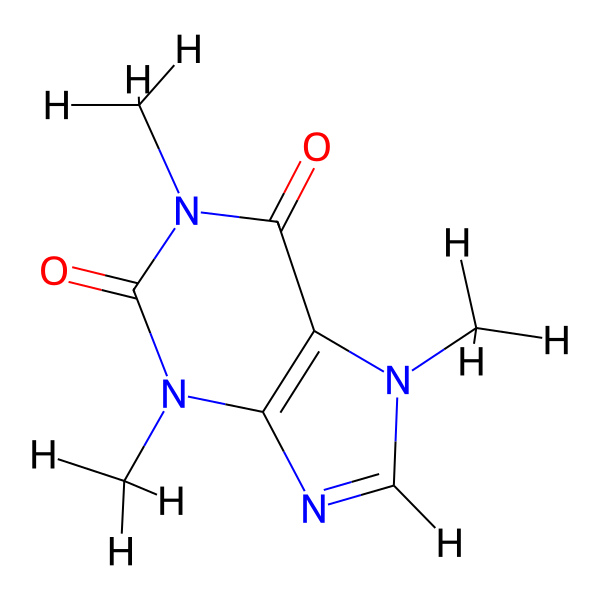

In [9]:
# attach it to the mol
from etflow.commons.featurization import get_mol_from_smiles
from etflow.commons.covmat import set_rdmol_positions

# Generate conformer
mol = get_mol_from_smiles(smiles)
gen_idx = 0 # 0th conformer generated
mol = set_rdmol_positions(mol, gen_position[gen_idx])
mol